Diana Covaci, 261 086 280

Nicholas Milin, 261 106 314

Viktor Allais, 261 148 866

In [2]:
!pip install -q numpy pandas matplotlib seaborn 
!pip install -q torchvision

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import copy
import time
import os
import pickle
import importlib
import pandas as pd



### Helper Functions - Save and Load Models

In [3]:
# Utility functions for saving and loading models
# will use to cache experiments to avoid retraining models and to allow reproducible results
def save_model(model, filename, directory='saved_models'):
    """Save a model to disk
    Args:
        model: The model to save
        filename: Name of the file (will add .pkl if not present)
        directory: Directory to save in (will be created if it doesn't exist)
    """
    if not filename.endswith('.pkl'):
        filename += '.pkl'
    
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    filepath = os.path.join(directory, filename)
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {filepath}")
    
def load_model(filename, directory='saved_models'):
    """Load a model from disk
    Args:
        filename: Name of the file (will add .pkl if not present)
        directory: Directory to load from
    Returns:
        The loaded model
    """
    if not filename.endswith('.pkl'):
        filename += '.pkl'
        
    filepath = os.path.join(directory, filename)
    if not os.path.exists(filepath):
        print(f"No saved model found at {filepath}")
        return None
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    print(f"Model loaded from {filepath}")
    return model

# Task 1: Acquire the data

In [4]:
# find mean & std for train_dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
loader_iter = iter(loader)
images, _ = next(loader_iter)
mean_train = images.mean().item()
std_train = images.std().item()
print((mean_train, std_train))

# normalize train_dataset & test_dataset
mlp_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
    transforms.Lambda(lambda x:x.view(-1))
])

full_train_dataset_normalized = datasets.FashionMNIST(root='./data', train=True, download=True, transform=mlp_transform)
test_dataset_normalized = datasets.FashionMNIST(root='./data', train=False, download=True, transform=mlp_transform)

# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_dataset_normalized))
val_size = len(full_train_dataset_normalized) - train_size

# Add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_normalized, val_dataset_normalized = random_split(full_train_dataset_normalized, [train_size, val_size], generator=generator)

# create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset_normalized, batch_size=batch_size, shuffle=True, generator=generator)
validation_loader = DataLoader(val_dataset_normalized, batch_size=batch_size, shuffle=False, generator=generator)
test_loader = DataLoader(test_dataset_normalized, batch_size=batch_size, shuffle=False, generator=generator)

# sanity check
x, y = next(iter(train_loader))
print((x.shape, y.shape)) # expect [64, 784] and [64]
input_size = x.shape[1]
output_size = len(set(full_train_dataset_normalized.targets.numpy()))
print(input_size, output_size)

(0.28604060411453247, 0.3530242443084717)
(torch.Size([64, 784]), torch.Size([64]))
784 10


['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


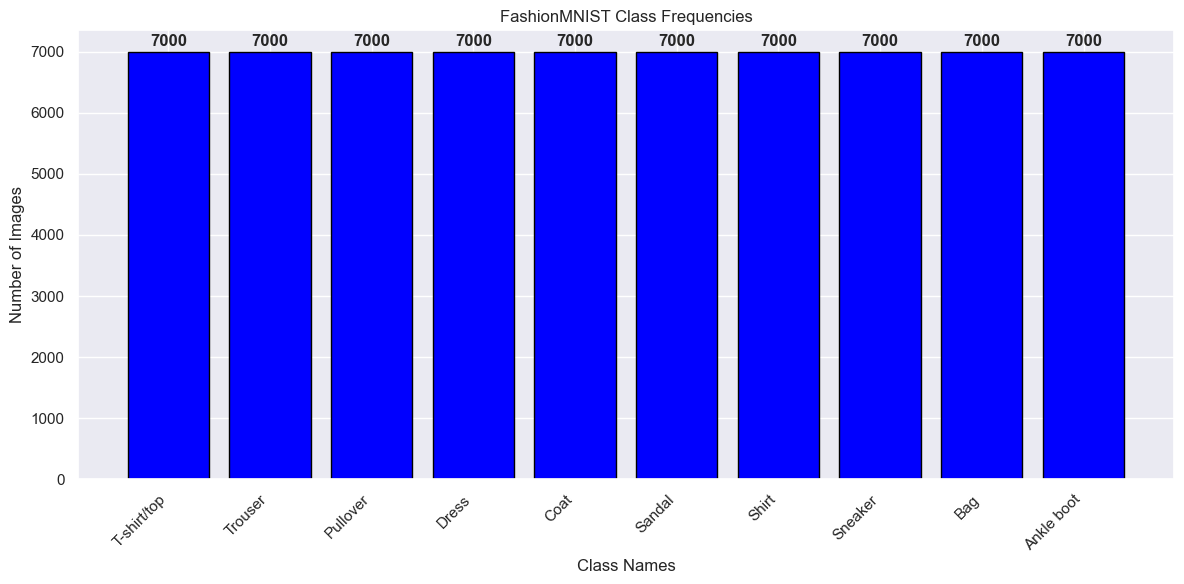

In [4]:
# Explore what classes of the dataset
class_names = full_train_dataset_normalized.classes
print(class_names)

all_labels = torch.cat([full_train_dataset_normalized.targets, test_dataset_normalized.targets])
unique, counts = np.unique(all_labels.numpy(), return_counts=True)

plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, counts, color='blue', edgecolor='black')
plt.title('FashionMNIST Class Frequencies')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')

for bar, count in zip(bars, counts): 
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


# Task 2: Implement a Multilayer Perceptron

In [54]:
import mlp                # only required if not already imported
importlib.reload(mlp)     # reloads the module from disk
from mlp import MLP, softmax, evaluate_acc  # rebinds names in notebook namespace

import activation_functions
importlib.reload(activation_functions)  # reloads the module from disk
from activation_functions import relu, leakyRelu, sigmoid, tanh  # rebinds names in notebook namespace

# Task 3: Run the experiments and report

## 3.0: Hyperparameter Tuning

### Learning Rate

In [58]:
# comparison of learning rates
lrs = [0.001, 0.005, 0.01, 0.05, 0.1]

accuracies = {
    "Learning Rate": [],
    "Validation Accuracy": []
}

for lr in lrs:
    model = load_model(f'model_lr_{lr}')

    if model is None:
        model = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=2, units=[256,256])
        model.fit_validation(train_loader, validation_loader, learning_rate=lr, epochs=20)
        save_model(model, f'model_lr_{lr}')    
    
    val_accuracy = model.val_accuracy_history[-1]

    accuracies["Learning Rate"].append(lr)
    accuracies["Validation Accuracy"].append(val_accuracy)

# table comparison of learning rates
df = pd.DataFrame(accuracies)
print(df)

Model loaded from saved_models/model_lr_0.001.pkl
Model loaded from saved_models/model_lr_0.005.pkl
Model loaded from saved_models/model_lr_0.01.pkl
Model loaded from saved_models/model_lr_0.05.pkl
Model loaded from saved_models/model_lr_0.1.pkl
   Learning Rate  Validation Accuracy
0          0.001             0.852167
1          0.005             0.879583
2          0.010             0.885917
3          0.050             0.883833
4          0.100             0.886333


Model loaded from saved_models/model_lr_0.001.pkl
Model loaded from saved_models/model_lr_0.005.pkl
Model loaded from saved_models/model_lr_0.01.pkl
Model loaded from saved_models/model_lr_0.05.pkl
Model loaded from saved_models/model_lr_0.1.pkl


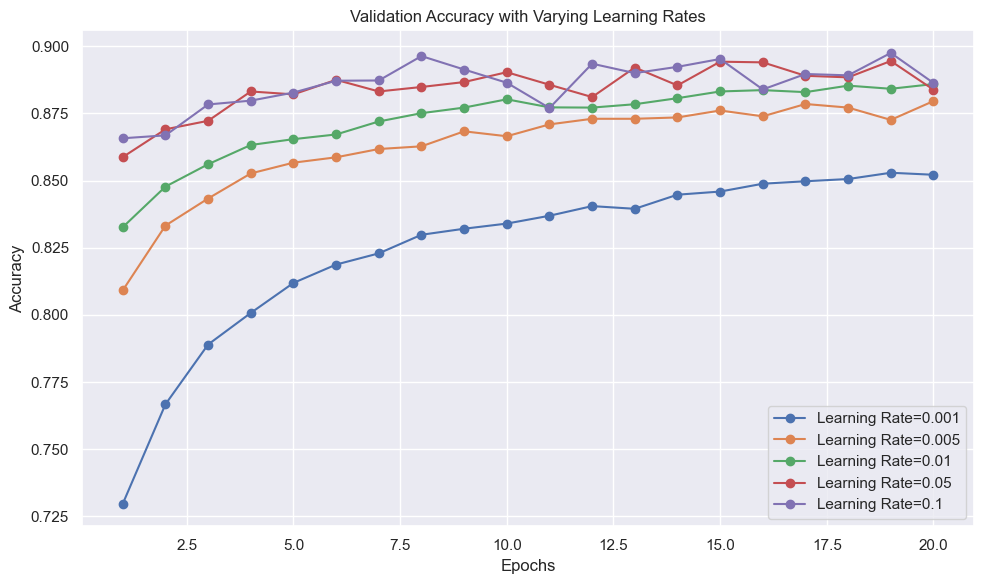

In [ ]:
plt.figure(figsize=(10, 6))

for lr in lrs:
    model = load_model(f'model_lr_{lr}')
    if model is None:
        continue
    epochs = range(1, len(model.val_accuracy_history) + 1)
    plt.plot(epochs, model.val_accuracy_history, marker='o', label=f'Learning Rate={lr}')

plt.title('Validation Accuracy with Varying Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Batch Size

In [63]:
batch_sizes = [16, 32, 64, 128]
best_lr = 0.1

accuracies = {
    "Batch Size": [],
    "Validation Accuracy": []
}

for batch in batch_sizes:
    train_loader = DataLoader(train_dataset_normalized, batch_size=batch, shuffle=True, generator=generator)
    validation_loader = DataLoader(val_dataset_normalized, batch_size=batch, shuffle=False, generator=generator)

    model = load_model(f'model_bs_{batch}')

    if model is None:
        model = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=2, units=[256,256])
        model.fit_validation(train_loader, validation_loader, learning_rate=best_lr, epochs=10)
        save_model(model, f'model_bs_{batch}')    
    
    val_accuracy = model.val_accuracy_history[-1]

    accuracies["Batch Size"].append(batch)
    accuracies["Validation Accuracy"].append(val_accuracy)

# table comparison of learning rates
df = pd.DataFrame(accuracies)
print(df)

Model loaded from saved_models/model_bs_16.pkl
Model loaded from saved_models/model_bs_32.pkl
Model loaded from saved_models/model_bs_64.pkl
Model loaded from saved_models/model_bs_128.pkl
   Batch Size  Validation Accuracy
0          16             0.875417
1          32             0.874167
2          64             0.889833
3         128             0.889833


Model loaded from saved_models/model_bs_16.pkl
Model loaded from saved_models/model_bs_32.pkl
Model loaded from saved_models/model_bs_64.pkl
Model loaded from saved_models/model_bs_128.pkl


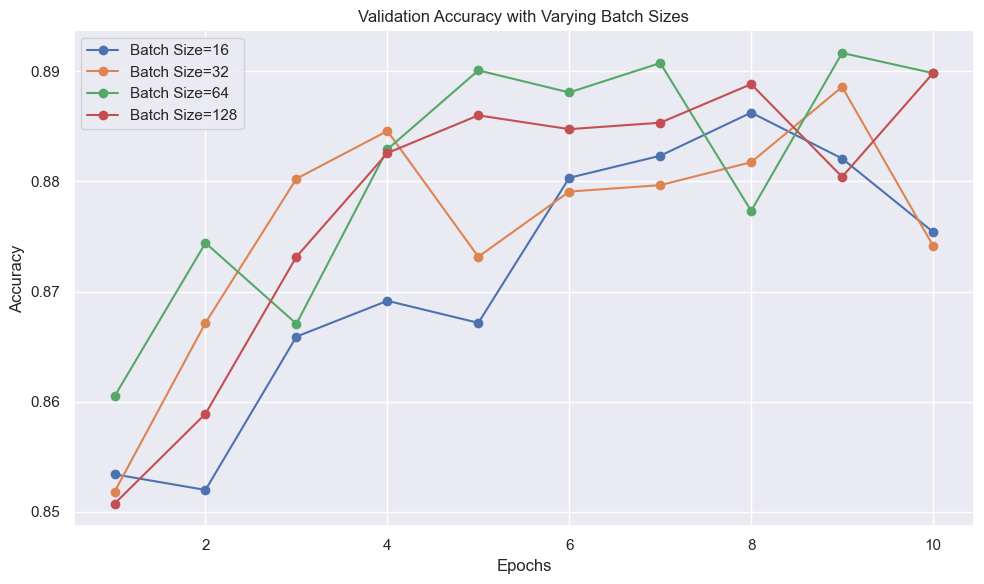

In [ ]:
plt.figure(figsize=(10, 6))

for batch in batch_sizes:
    model = load_model(f'model_bs_{batch}')
    if model is None:
        continue
    epochs = range(1, len(model.val_accuracy_history) + 1)
    plt.plot(epochs, model.val_accuracy_history, marker='o', label=f'Batch Size={batch}')

plt.title('Validation Accuracy with Varying Batch Sizes')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.1: MLPs with Different Depths

### No Hidden Layers

Model loaded from saved_models/model1.1.pkl


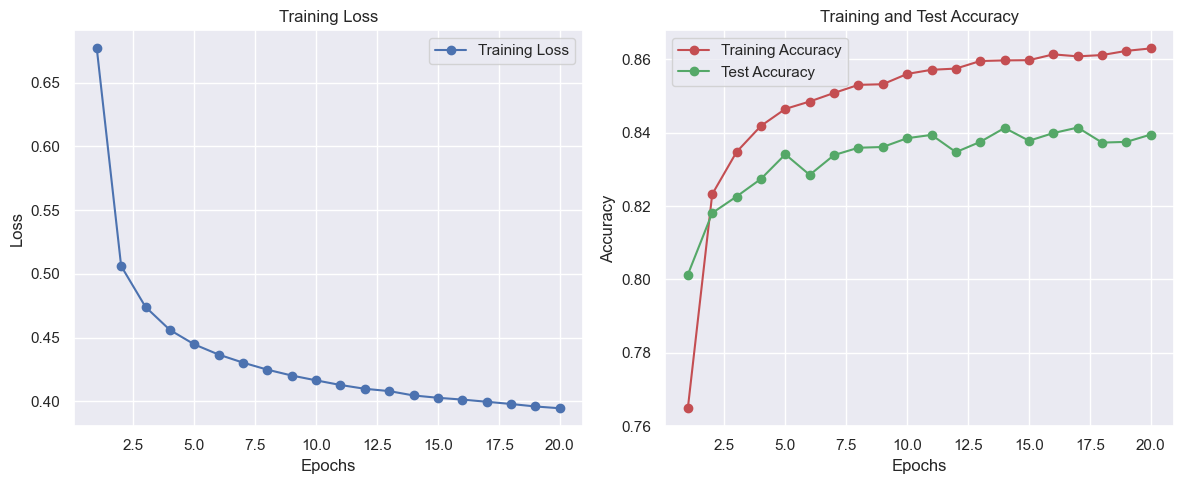

In [ ]:
# Model 1 - No hidden layers, ReLU activation
model1 = load_model('model1.1')
if model1 is None: 
    model1 = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=0, units=[])
    model1.fit(train_loader, test_loader, 0.01, 20) 
    model1.plot_history()
    save_model(model1, 'model1.1')
else: 
    model1.plot_history()

### One Hidden Layer

Model loaded from saved_models/model1.2.pkl


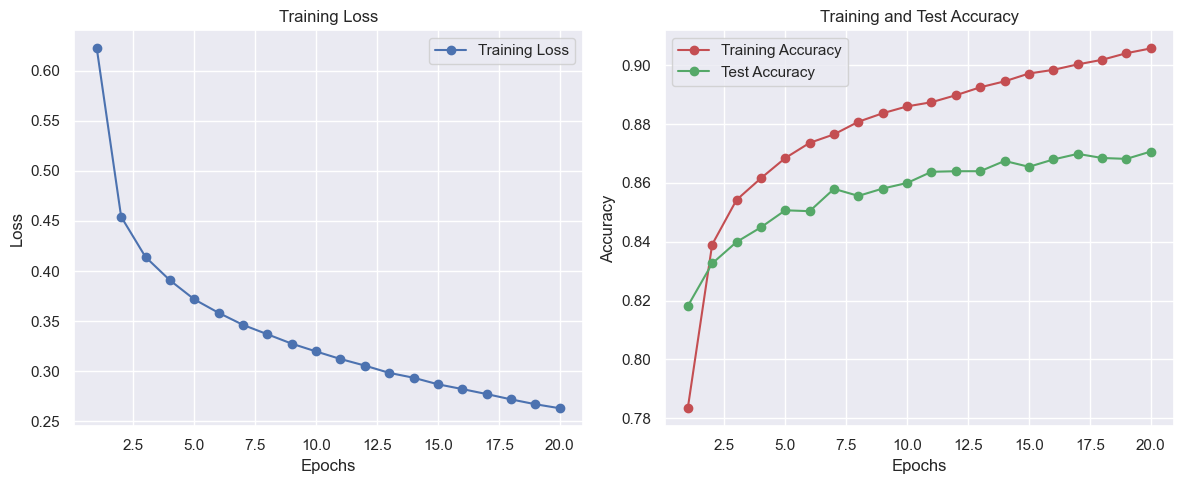

In [ ]:
# Model 2 - One hidden layer with 256 units, ReLU activation
model2 = load_model('model1.2')
if model2 is None: 
    model2 = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=1, units=[256])
    model2.fit(train_loader, test_loader, 0.01, 20) 
    model2.plot_history()
    save_model(model2, 'model1.2')
else: 
    model2.plot_history()

### Two Hidden Layers

Model loaded from saved_models/model1.3.pkl


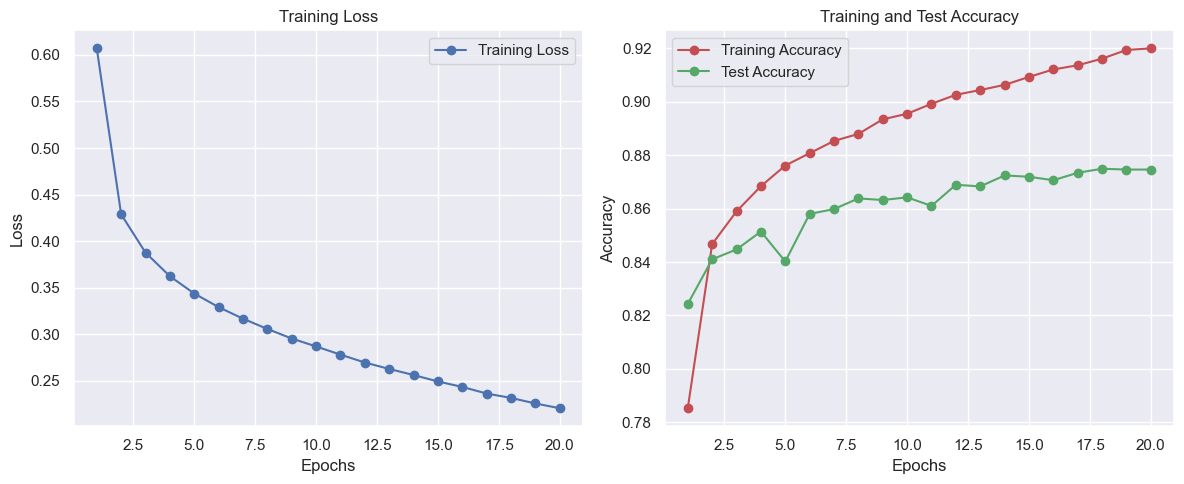

In [ ]:
# Model 3 - Two hidden layers with 256 units each, ReLU activation
model3 = load_model('model1.3')
if model3 is None: 
    model3 = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=2, units=[256,256])
    model3.fit(train_loader, test_loader, 0.01, 20) 
    model3.plot_history()
    save_model(model3, 'model1.3')
else: 
    model3.plot_history()

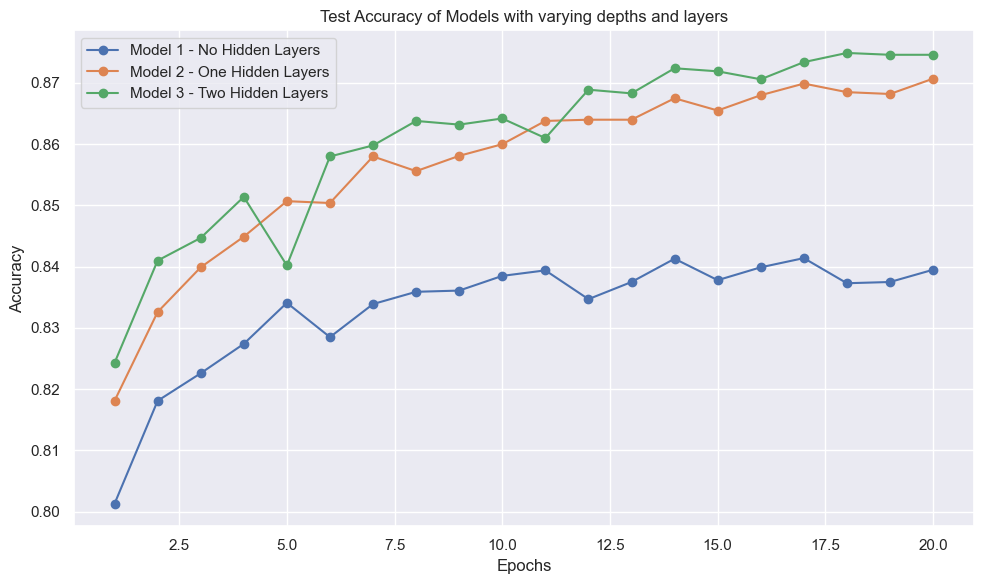

In [103]:
# Comparison of models test accuracy
models = [('Model 1 - No Hidden Layers', model1), ('Model 2 - One Hidden Layers', model2), ('Model 3 - Two Hidden Layers', model3)]
plt.figure(figsize=(10, 6))
for model_name, model in models:
    if model is None: 
        continue
    epochs = range(1, len(model.loss_history) + 1)
    plt.plot(epochs, model.test_accuracy_history, marker='o', label=model_name)
plt.title('Test Accuracy of Models with varying depths and layers')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.2: Activation Function Comparison

### Two Hidden Layers - Tanh Activation

Model loaded from saved_models/model2.1.pkl


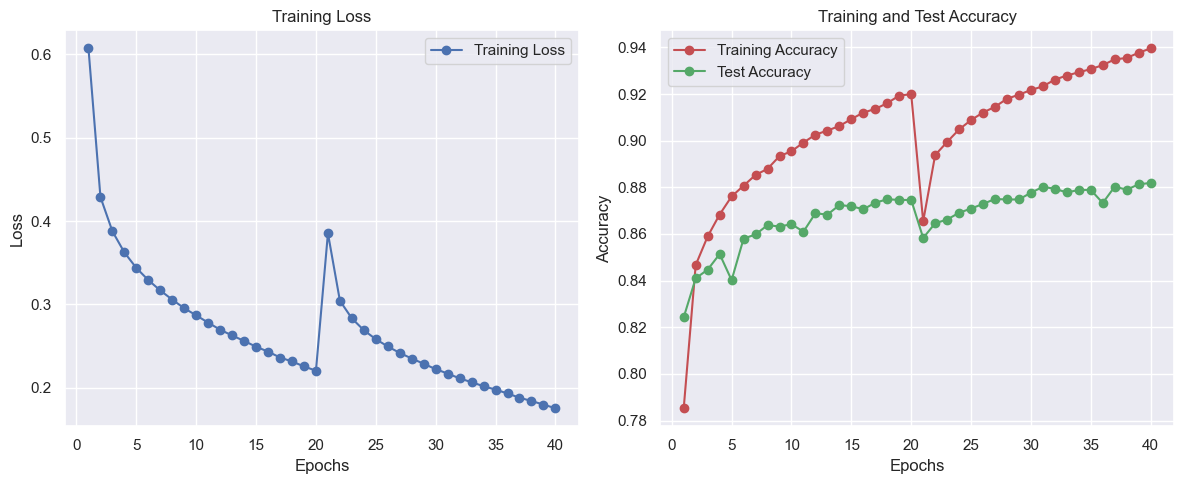

In [ ]:
# Copy of model with 2 hidden layers with tanh activation function
model3_tanh = load_model('model2.1')
if model3_tanh is None:
    model3_ReLU = load_model('model1.3')
    if model3_ReLU is not None: 
        model3_tanh = copy.deepcopy(model3_ReLU)
        model3_tanh.activation_function = tanh()
        model3_tanh.fit(train_loader, test_loader, 0.01, 20)
        model3_tanh.plot_history()
        save_model(model3_tanh, 'model2.1')
else: 
    model3_tanh.plot_history()

### Two Hidden Layers - Leaky ReLU Activation

Model loaded from saved_models/model2.2.pkl


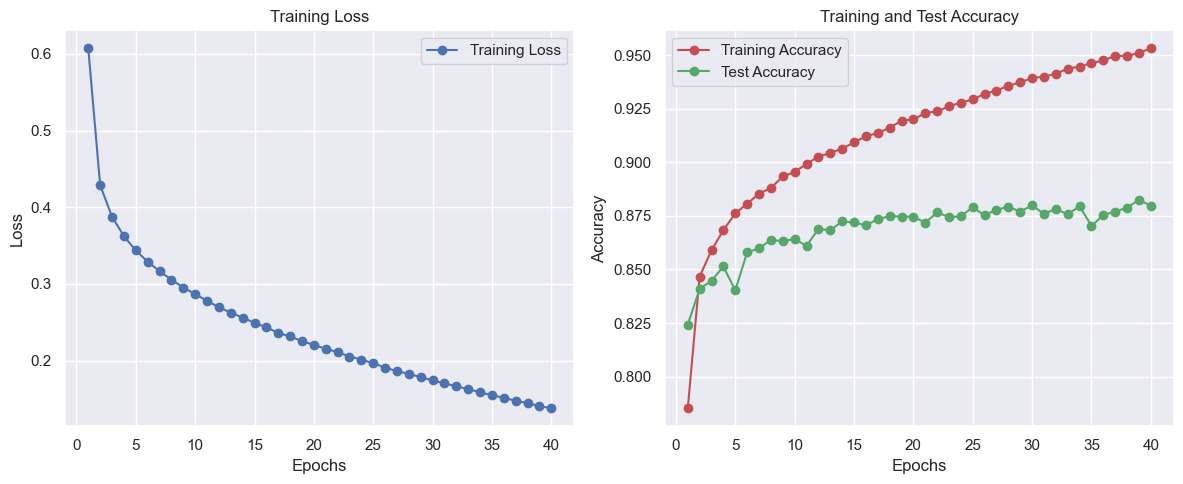

In [ ]:
# Copy of model with 2 hidden layers with leaky ReLU activation function
model3_leakyReLU = load_model('model2.2')
if model3_leakyReLU is None:
    model3_ReLU = load_model('model1.3')
    if model3_ReLU is not None: 
        model3_leakyReLU = copy.deepcopy(model3_ReLU)
        model3_leakyReLU.activation_function = leakyRelu()
        model3_leakyReLU.fit(train_loader, test_loader, 0.01, 20)
        model3_leakyReLU.plot_history()
        save_model(model3_leakyReLU, 'model2.2')
else: 
    model3_leakyReLU.plot_history()

### Two Hidden Layers - Sigmoid

Model loaded from saved_models/model2.3.pkl


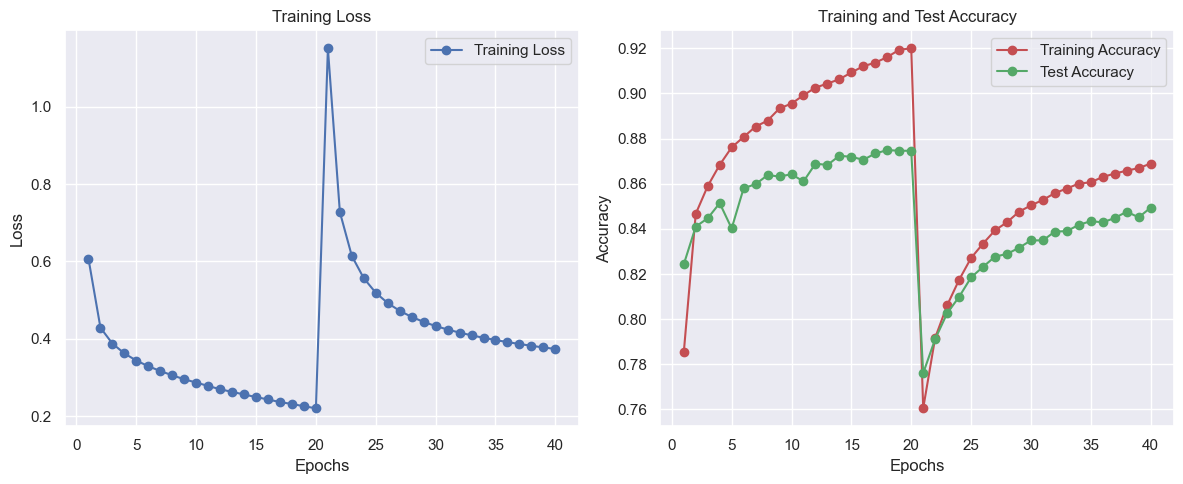

In [ ]:
# Copy of model with 2 hidden layers with leaky ReLU activation function
model3_sigmoid = load_model('model2.3')
if model3_sigmoid is None:
    model3_ReLU = load_model('model1.3')
    if model3_ReLU is not None: 
        model3_sigmoid = copy.deepcopy(model3_ReLU)
        model3_sigmoid.activation_function = sigmoid()
        model3_sigmoid.fit(train_loader, test_loader, 0.01, 20)
        model3_sigmoid.plot_history()
        save_model(model3_sigmoid, 'model2.3')
else: 
    model3_sigmoid.plot_history()

### Two Hidden Layers - ReLU

Model loaded from saved_models/model2.4.pkl


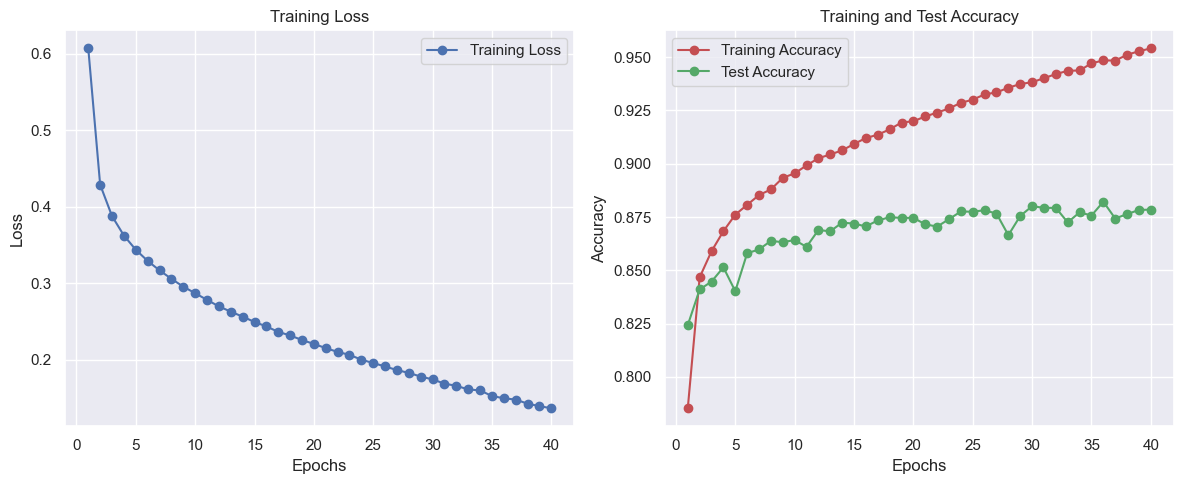

In [81]:
# Retrain model with 2 hidden layers 20 more times
model3_ReLU_Extra = load_model('model2.4')
if model3_ReLU_Extra is None:
    model3_ReLU = load_model('model1.3')
    if model3_ReLU is not None: 
        model3_ReLU_Extra = copy.deepcopy(model3_ReLU)
        model3_ReLU_Extra.fit(train_loader, test_loader, 0.01, 20)
        model3_ReLU_Extra.plot_history()
        save_model(model3_ReLU_Extra, 'model2.4')
else: 
    model3_ReLU_Extra.plot_history()

### Comparison

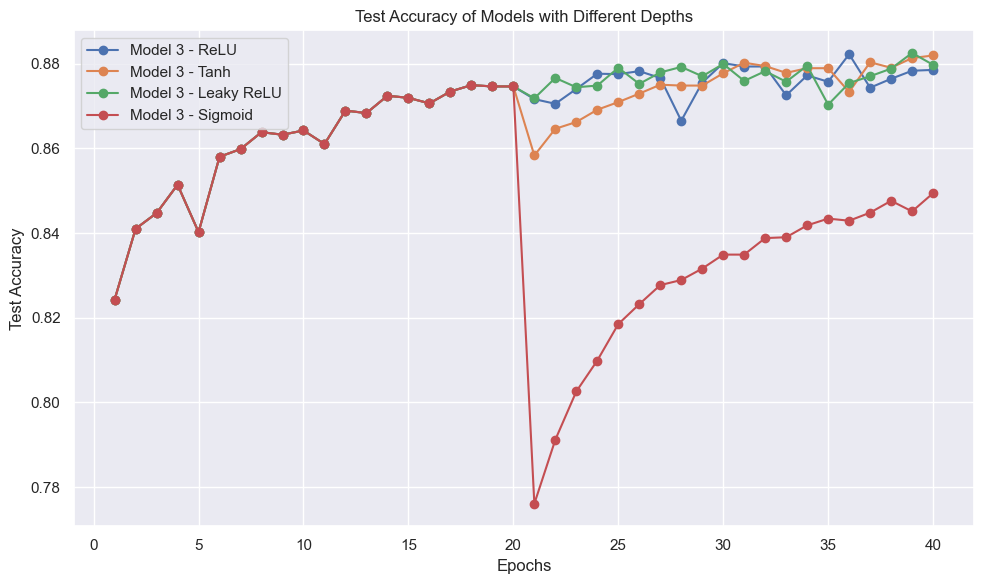

In [102]:
# Comparison of models test accuracy
models = [('Model 3 - ReLU', model3_ReLU_Extra), ('Model 3 - Tanh', model3_tanh), ('Model 3 - Leaky ReLU', model3_leakyReLU), ('Model 3 - Sigmoid', model3_sigmoid)]
plt.figure(figsize=(10, 6))
for model_name, model in models:
    if model is None: 
        continue
    epochs = range(1, len(model.loss_history) + 1)
    plt.plot(epochs, model.test_accuracy_history, marker='o', label=model_name)
plt.title('Test Accuracy of Models with Different Depths')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.3: L1 and L2 Regularization

Model loaded from saved_models/model3_lambda1_0.0.pkl
Model loaded from saved_models/model3_lambda1_0.0001.pkl
Model loaded from saved_models/model3_lambda1_0.001.pkl
Model loaded from saved_models/model3_lambda1_0.01.pkl
Model loaded from saved_models/model3_lambda1_0.1.pkl
Model loaded from saved_models/model3_lambda1_1.0.pkl


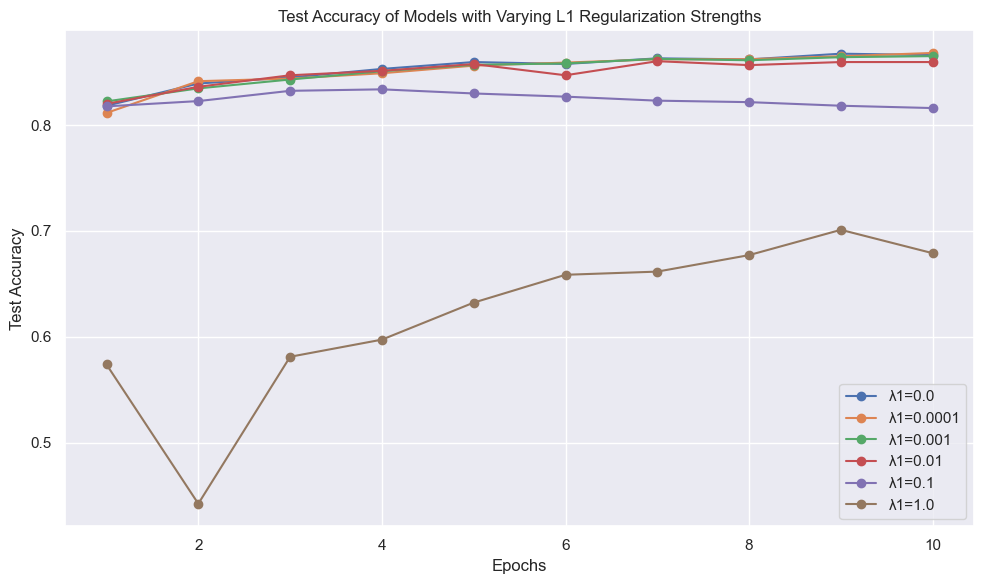

In [100]:
# Experimenting with L1 regularization strengths
lambda_ranges = np.concatenate((np.array([0]), np.logspace(-4, 0, 5)))
plt.figure(figsize=(10, 6))
for i, l in enumerate(lambda_ranges):
    model = load_model(f'model3_lambda1_{l}')
    if model is None:
        model = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=2, units=[256,256])
        model.fit(train_loader, test_loader, 0.01, 10, lambda_l1=l)
        save_model(model, f'model3_lambda1_{l}')
    plt.plot(range(1, len(model.test_accuracy_history) + 1), model.test_accuracy_history, marker='o', label=f'λ1={l}')

plt.title('Test Accuracy of Models with Varying L1 Regularization Strengths')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Model loaded from saved_models/model3_lambda2_0.0.pkl
Model loaded from saved_models/model3_lambda2_0.0001.pkl
Model loaded from saved_models/model3_lambda2_0.001.pkl
Model loaded from saved_models/model3_lambda2_0.01.pkl
Model loaded from saved_models/model3_lambda2_0.1.pkl
Model loaded from saved_models/model3_lambda2_1.0.pkl


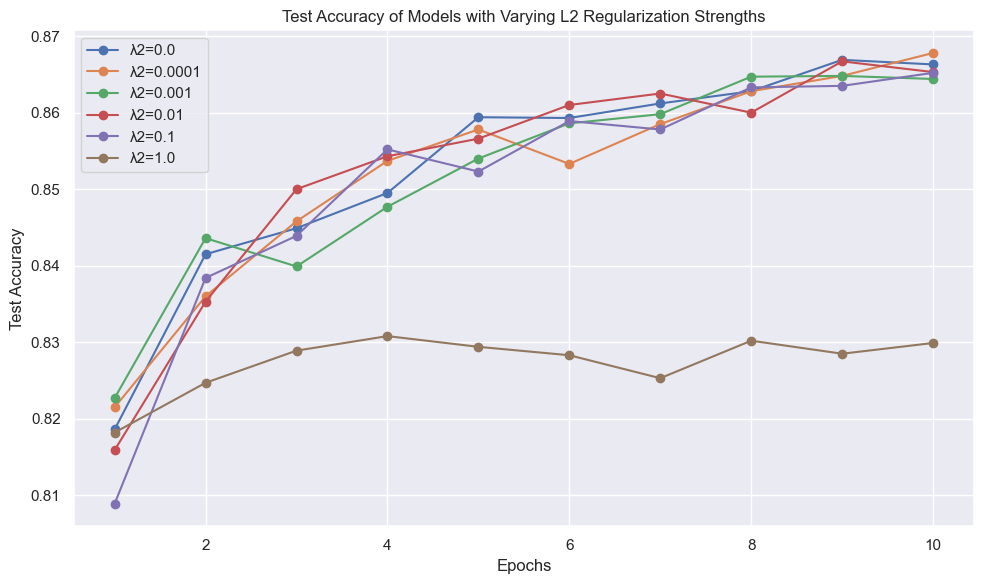

In [101]:
# Experimenting with L2 regularization strengths
plt.figure(figsize=(10, 6))
for i, l in enumerate(lambda_ranges):
    model = load_model(f'model3_lambda2_{l}')
    if model is None:
        model = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=2, units=[256,256])
        model.fit(train_loader, test_loader, 0.01, 10, lambda_l2=l)
        save_model(model, f'model3_lambda2_{l}')
    plt.plot(range(1, len(model.test_accuracy_history) + 1), model.test_accuracy_history, marker='o', label=f'λ2={l}')

plt.title('Test Accuracy of Models with Varying L2 Regularization Strengths')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.4: Unnormalized Images

### Unnormalized Transformation

In [9]:
# Model with unnormalized images
mlp_transform_unnormalized = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x:x.view(-1))
])
full_train_dataset_unnormalized = datasets.FashionMNIST(root='./data', train=True, download=True, transform=mlp_transform_unnormalized)
test_dataset_unnormalized = datasets.FashionMNIST(root='./data', train=False, download=True, transform=mlp_transform_unnormalized)
# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_dataset_unnormalized))
val_size = len(full_train_dataset_unnormalized) - train_size

# add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_unnormalized, val_dataset_unnormalized = random_split(full_train_dataset_unnormalized, [train_size, val_size], generator=generator)

# create dataloaders
batch_size = 64
train_loader_unnormalized = DataLoader(train_dataset_unnormalized, batch_size=batch_size, shuffle=True, generator=generator)
validation_loader_unnormalized = DataLoader(val_dataset_unnormalized, batch_size=batch_size, shuffle=False, generator=generator)
test_loader_unnormalized = DataLoader(test_dataset_unnormalized, batch_size=batch_size, shuffle=False, generator=generator)

### Load Models

In [106]:
# comparison of unnormalized model vs normalized model
model_unnormalized = load_model('model3.4_unnormalized')
model_normalized = load_model('model1.3')
if model_unnormalized is None: 
    model_unnormalized = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=2, units=[256,256])
    model_unnormalized.fit(train_loader_unnormalized, test_loader_unnormalized, 0.01, 20)
    save_model(model_unnormalized, 'model3.4_unnormalized')

Model loaded from saved_models/model3.4_unnormalized.pkl
Model loaded from saved_models/model1.3.pkl


### Plot Results

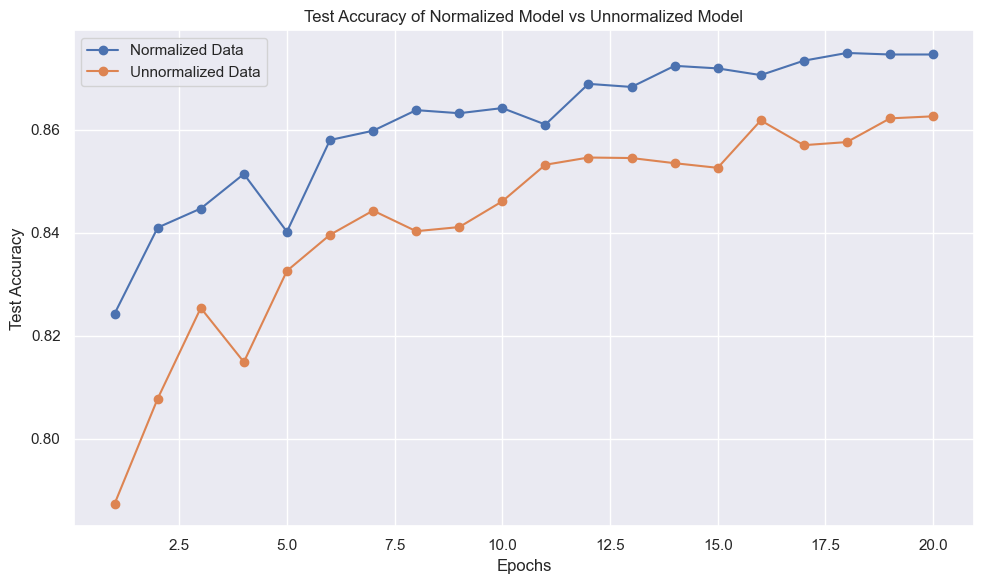

In [107]:
if model_unnormalized is None:
    raise ValueError("Normalized model not loaded properly.")

if model_normalized is None:
    raise ValueError("Augmented model not loaded properly.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(model_normalized.test_accuracy_history) + 1), model_normalized.test_accuracy_history, marker='o', label=f'Normalized Data')
plt.plot(range(1, len(model_unnormalized.test_accuracy_history) + 1),model_unnormalized.test_accuracy_history, marker='o', label=f'Unnormalized Data')
plt.title('Test Accuracy of Normalized Model vs Unnormalized Model')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.5 MLP with Data Augmentation

### Data Augmentation Transformation

In [10]:
# Model with data augmentation (random horizontal flip and random rotation)
mlp_transform_data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])
full_train_dataset_data_augmentation = datasets.FashionMNIST(root='./data', train=True, download=True, transform=mlp_transform_data_augmentation)
# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_dataset_data_augmentation))
val_size = len(full_train_dataset_data_augmentation) - train_size

# add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_data_augmentation, val_dataset_data_augmentation = random_split(full_train_dataset_data_augmentation, [train_size, val_size], generator=generator)

# create dataloader -- note that we use the same test_loader as before (no augmentation on test set)
batch_size = 64
train_loader_data_augmentation = DataLoader(train_dataset_data_augmentation, batch_size=batch_size, shuffle=True, generator=generator)

### Load Models

In [ ]:
# comparison of augmented model vs normalized model
model_augmented = load_model('model3.5_augmented')
model_normalized = load_model('model1.3')

if model_augmented is None: 
    model_augmented = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=2, units=[256,256])
    model_augmented.fit(train_loader_unnormalized, test_loader_unnormalized, 0.01, 20)
    save_model(model_augmented, 'model3.5_augmented')


### Plot Results

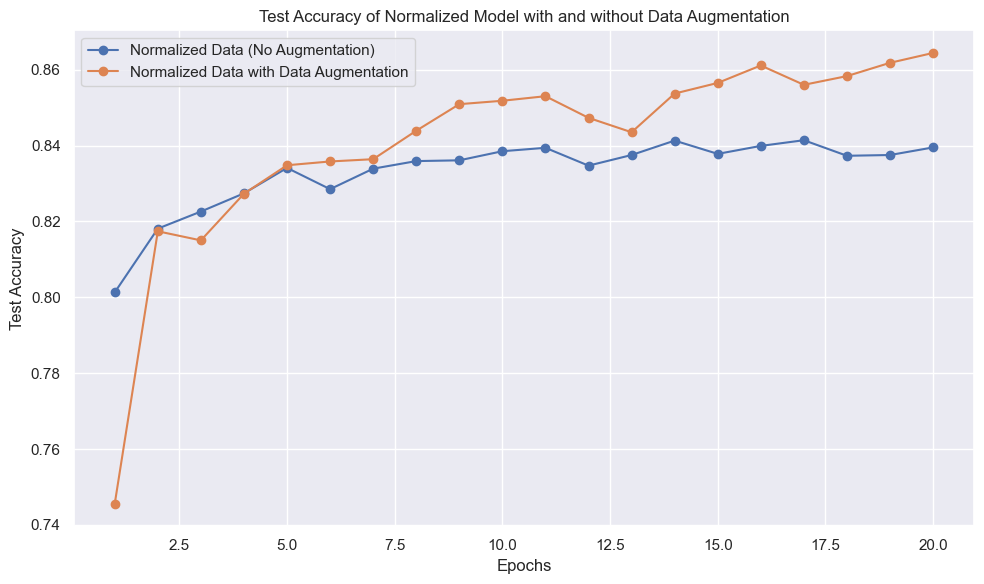

In [99]:
if model_normalized is None:
    raise ValueError("Normalized model not loaded properly.")

if model_augmented is None:
    raise ValueError("Augmented model not loaded properly.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(model_normalized.test_accuracy_history) + 1), model_normalized.test_accuracy_history, marker='o', label=f'Normalized Data (No Augmentation)')
plt.plot(range(1, len(model_augmented.test_accuracy_history) + 1), model_augmented.test_accuracy_history, marker='o', label=f'Normalized Data with Data Augmentation')
plt.title('Test Accuracy of Normalized Model with and without Data Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
model_augmented = load_model('model3.5_augmented')
print(model_augmented.test_accuracy_history)  # type: ignore

Model loaded from saved_models/model3.5_augmented.pkl
[np.float64(0.7456), np.float64(0.8174), np.float64(0.815), np.float64(0.8273), np.float64(0.8348), np.float64(0.8358), np.float64(0.8364), np.float64(0.8439), np.float64(0.8509), np.float64(0.8518), np.float64(0.853), np.float64(0.8473), np.float64(0.8435), np.float64(0.8537), np.float64(0.8565), np.float64(0.8611), np.float64(0.856), np.float64(0.8583), np.float64(0.8618), np.float64(0.8644)]


## 3.6: CNN Using Pytorch

### CNN-specific Data Transformation

In [5]:
# Create CNN-specific transforms
cnn_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

full_train_cnn = datasets.FashionMNIST(root='./data', train=True, download=True, transform=cnn_transform)
test_dataset_cnn = datasets.FashionMNIST(root='./data', train=False, download=True, transform=cnn_transform)

# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_cnn))
val_size = len(full_train_cnn) - train_size

# Add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_cnn, val_dataset_cnn = random_split(full_train_cnn, [train_size, val_size], generator=generator)

# create dataloaders
batch_size = 64
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size, shuffle=True, generator=generator)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=batch_size, shuffle=False, generator=generator)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=batch_size, shuffle=False, generator=generator)

# sanity check
x_cnn, y_cnn = next(iter(train_loader_cnn))
print((x_cnn.shape, y_cnn.shape)) # expect [64, 1, 28, 28] and [64]

(torch.Size([64, 1, 28, 28]), torch.Size([64]))


### CCN Class

In [12]:
## Import CNN implementation from cnn.py
import cnn                
importlib.reload(cnn)     # reloads the module from disk
from cnn import CNN

# Device (use GPU if available but don't change MLP behavior)
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
if device == "cpu":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Using device:', device)

Using device: mps


### CNN Hyperparameter Tuning

#### Learning Rates

In [8]:
# comparison of learning rates
lrs = [0.001, 0.005, 0.01, 0.05, 0.1]

# Initialize empty DataFrame
columns = ["LR", "Validation Loss", "Validation Accuracy"]
df = pd.DataFrame()

for lr in lrs:
    cnn_model = load_model(f'cnn_model_lr_{lr}')

    if cnn_model is None:
        cnn_model = CNN().to(device)
        optimizer = optim.Adam(cnn_model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()
        cnn_model.train_cnn(20, optimizer, loss_fn, train_loader_cnn, val_loader_cnn, test_loader_cnn, device)
        save_model(cnn_model, f'cnn_model_lr_{lr}')
    
    validation_loss = cnn_model.val_losses_cnn[-1]
    validation_accuracy = cnn_model.val_accuracies_cnn[-1]

    new_row = pd.DataFrame([[lr, validation_loss, validation_accuracy]], columns=columns)
    df = pd.concat([df, new_row], ignore_index=True)

# table comparison of learning rates
print(df)

Model loaded from saved_models/cnn_model_lr_0.001.pkl
Model loaded from saved_models/cnn_model_lr_0.005.pkl
Model loaded from saved_models/cnn_model_lr_0.01.pkl
Model loaded from saved_models/cnn_model_lr_0.05.pkl
Model loaded from saved_models/cnn_model_lr_0.1.pkl
      LR  Validation Loss  Validation Accuracy
0  0.001         0.467081             0.922167
1  0.005         0.491892             0.893500
2  0.010         0.385755             0.878583
3  0.050         2.311386             0.098667
4  0.100         2.308781             0.096500


Model loaded from saved_models/cnn_model_lr_0.001.pkl
Model loaded from saved_models/cnn_model_lr_0.005.pkl
Model loaded from saved_models/cnn_model_lr_0.01.pkl
Model loaded from saved_models/cnn_model_lr_0.05.pkl
Model loaded from saved_models/cnn_model_lr_0.1.pkl


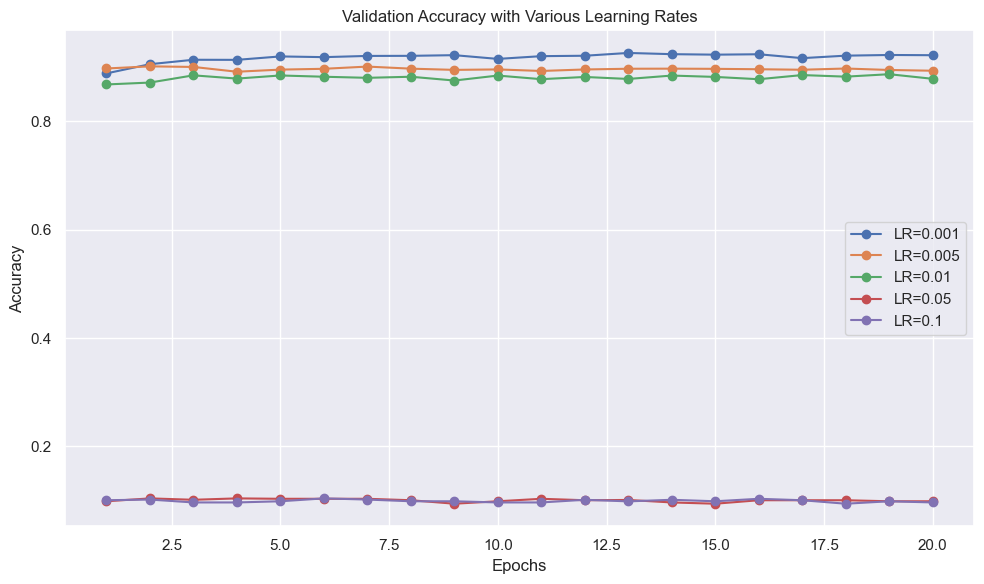

In [9]:
plt.figure(figsize=(10, 6))
clipped_lrs = [0.001, 0.005, 0.01]
for lr in lrs:
    cnn_model = load_model(f'cnn_model_lr_{lr}')
    if cnn_model is None:
        continue
    epochs = range(1, len(cnn_model.val_losses_cnn) + 1)
    plt.plot(epochs, cnn_model.val_accuracies_cnn, marker='o', label=f'LR={lr}')

plt.title('Validation Accuracy with Various Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()


Model loaded from saved_models/cnn_model_lr_0.001.pkl
Model loaded from saved_models/cnn_model_lr_0.005.pkl
Model loaded from saved_models/cnn_model_lr_0.01.pkl


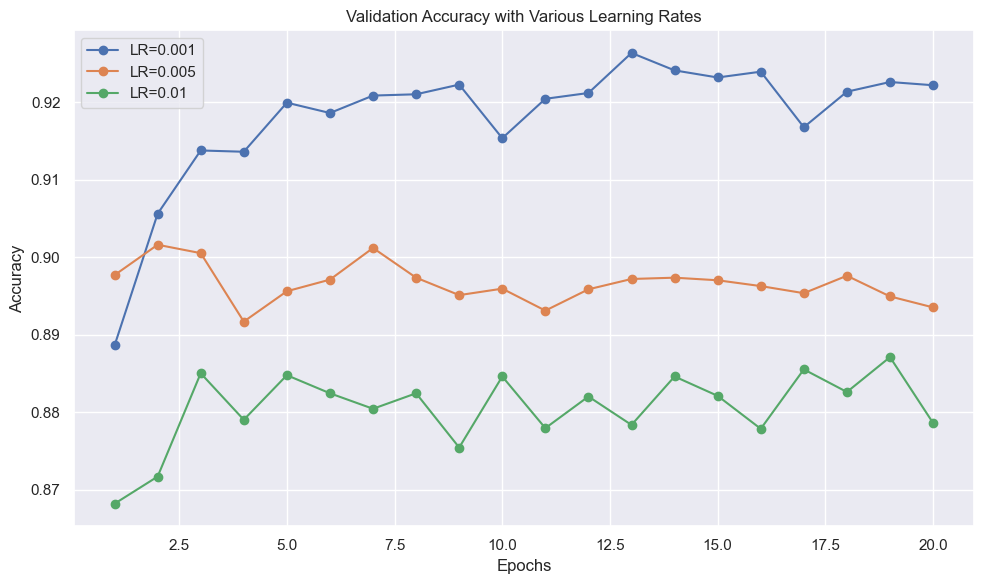

In [10]:
plt.figure(figsize=(10, 6))
clipped_lrs = [0.001, 0.005, 0.01]
for lr in clipped_lrs:
    cnn_model = load_model(f'cnn_model_lr_{lr}')
    if cnn_model is None:
        continue
    epochs = range(1, len(cnn_model.val_losses_cnn) + 1)
    plt.plot(epochs, cnn_model.val_accuracies_cnn, marker='o', label=f'LR={lr}')

plt.title('Validation Accuracy with Various Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

In [23]:
acc_matrix = {}

for lr in lrs:
    cnn_model = load_model(f'cnn_model_lr_{lr}')
    if cnn_model is None:
        continue

    # Each LR becomes a row
    acc_matrix[lr] = {epoch+1: acc for epoch, acc in enumerate(cnn_model.val_accuracies_cnn)}

# Convert into a dataframe with rows = LRs, cols = Epochs
df = pd.DataFrame.from_dict(acc_matrix, orient='index')

df.index.name = "Learning Rate"
df.columns.name = "Epoch"

display(df)


Model loaded from saved_models/cnn_model_lr_0.001.pkl
Model loaded from saved_models/cnn_model_lr_0.005.pkl
Model loaded from saved_models/cnn_model_lr_0.01.pkl
Model loaded from saved_models/cnn_model_lr_0.05.pkl
Model loaded from saved_models/cnn_model_lr_0.1.pkl


Epoch,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Learning Rate,,,,,,,,,,,,,,,,,,,,
0.001,0.888583,0.905583,0.913750,0.913583,0.919917,0.918583,0.920833,0.921000,0.922250,0.915333,0.920417,0.921167,0.926333,0.924083,0.923167,0.923917,0.916750,0.921333,0.922583,0.922167
0.005,0.897667,0.901583,0.900500,0.891667,0.895583,0.897083,0.901167,0.897333,0.895083,0.895917,0.893083,0.895833,0.897167,0.897333,0.897000,0.896250,0.895333,0.897583,0.894917,0.893500
0.010,0.868167,0.871667,0.885000,0.879000,0.884750,0.882417,0.880417,0.882417,0.875417,0.884583,0.877917,0.882000,0.878333,0.884583,0.882083,0.877833,0.885500,0.882583,0.887083,0.878583
0.050,0.098667,0.104000,0.101417,0.104000,0.103250,0.103250,0.103250,0.100583,0.094167,0.098667,0.103250,0.100583,0.101083,0.096500,0.094167,0.100583,0.100583,0.100583,0.098667,0.098667
0.100,0.100583,0.101833,0.096500,0.096500,0.098667,0.104000,0.101833,0.098667,0.098667,0.096500,0.096500,0.101417,0.098500,0.101417,0.098667,0.103250,0.100583,0.094167,0.098667,0.096500


#### Batch size

In [25]:
# create dataloaders
batch_sizes = [32, 64, 128]

# Initialize empty DataFrame
columns = ["Batch Size", "Validation Loss", "Validation Accuracy"]
df = pd.DataFrame()


for batch_size in batch_sizes:
    train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size, shuffle=True, generator=generator)
    val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=batch_size, shuffle=False, generator=generator)
    test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=batch_size, shuffle=False, generator=generator)

    cnn_model = load_model(f'cnn_model_batch_{batch_size}')

    if cnn_model is None:
        learning_rate = 0.001
        cnn_model = CNN().to(device)
        optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)
        loss_fn = nn.CrossEntropyLoss()
        cnn_model.train_cnn(20, optimizer, loss_fn, train_loader_cnn, val_loader_cnn, test_loader_cnn, device)
        save_model(cnn_model, f'cnn_model_batch_{batch_size}')
    
    validation_loss = cnn_model.val_losses_cnn[-1]
    validation_accuracy = cnn_model.val_accuracies_cnn[-1]

    new_row = pd.DataFrame([[batch_size, validation_loss, validation_accuracy]], columns=columns)
    df = pd.concat([df, new_row], ignore_index=True)

# table comparison of learning rates
print(df)

Model loaded from saved_models/cnn_model_batch_32.pkl
Model loaded from saved_models/cnn_model_batch_64.pkl
Model loaded from saved_models/cnn_model_batch_128.pkl
   Batch Size  Validation Loss  Validation Accuracy
0          32         0.567449             0.919083
1          64         0.512745             0.920833
2         128         0.394224             0.920083


Model loaded from saved_models/cnn_model_batch_32.pkl
Model loaded from saved_models/cnn_model_batch_64.pkl
Model loaded from saved_models/cnn_model_batch_128.pkl


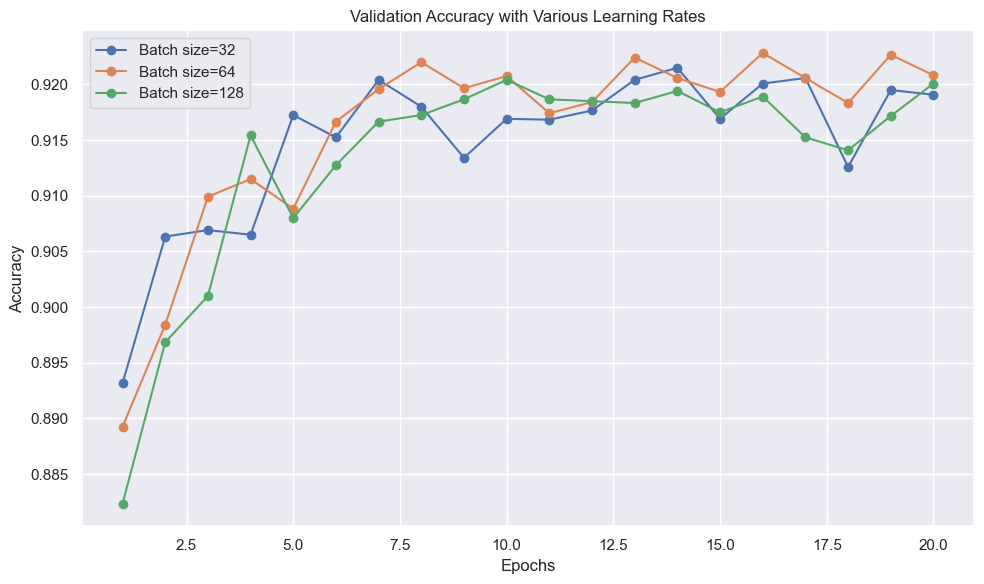

In [ ]:
plt.figure(figsize=(10, 6))

for batch_size in batch_sizes:
    cnn_model = load_model(f'cnn_model_batch_{batch_size}')
    if cnn_model is None:
        continue
    epochs = range(1, len(cnn_model.val_losses_cnn) + 1)
    plt.plot(epochs, cnn_model.val_accuracies_cnn, marker='o', label=f'Batch size={batch_size}')

plt.title('Validation Accuracy with Various Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()


In [27]:
acc_matrix = {}

for batch_size in batch_sizes:
    cnn_model = load_model(f'cnn_model_batch_{batch_size}')
    if cnn_model is None:
        continue

    # Each Batch Size becomes a row
    acc_matrix[batch_size] = {epoch+1: acc for epoch, acc in enumerate(cnn_model.val_accuracies_cnn)}

# Convert into a dataframe with rows = Batch Size, cols = Epochs
df = pd.DataFrame.from_dict(acc_matrix, orient='index')

df.index.name = "Batch Size"
df.columns.name = "Epoch"

display(df)

Model loaded from saved_models/cnn_model_batch_32.pkl
Model loaded from saved_models/cnn_model_batch_64.pkl
Model loaded from saved_models/cnn_model_batch_128.pkl


Epoch,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Batch Size,,,,,,,,,,,,,,,,,,,,
32,0.893167,0.906333,0.906917,0.906500,0.917250,0.915250,0.920417,0.91800,0.913417,0.916917,0.916833,0.917667,0.920417,0.921500,0.916917,0.920083,0.920583,0.912583,0.919500,0.919083
64,0.889250,0.898417,0.909917,0.911500,0.908833,0.916667,0.919583,0.92200,0.919667,0.920750,0.917417,0.918417,0.922417,0.920583,0.919333,0.922833,0.920583,0.918333,0.922667,0.920833
128,0.882333,0.896833,0.901000,0.915417,0.908000,0.912750,0.916667,0.91725,0.918667,0.920417,0.918667,0.918500,0.918333,0.919417,0.917500,0.918917,0.915250,0.914083,0.917167,0.920083


In [ ]:
batch_size = 64
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size, shuffle=True, generator=generator)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=batch_size, shuffle=False, generator=generator)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=batch_size, shuffle=False, generator=generator)
cnn = load_model('cnn_model_batch_64')
save_model(cnn, 'cnn_model_tuned')

Model loaded from saved_models/cnn_model_batch_64.pkl
Model saved to saved_models/cnn_model_tuned.pkl


### CNN Initialization and Training

In [ ]:
# Initialize CNN model and train
cnn = load_model('cnn_model_tuned')
if cnn is None: 
    learning_rate = 0.001
    cnn = CNN().to(device)
    optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    cnn.train_cnn(20, optimizer, loss_fn, train_loader_cnn, val_loader_cnn, test_loader_cnn, device)
    save_model(cnn, 'cnn_model_tuned')


Model loaded from saved_models/cnn_model_tuned.pkl


### Plot results

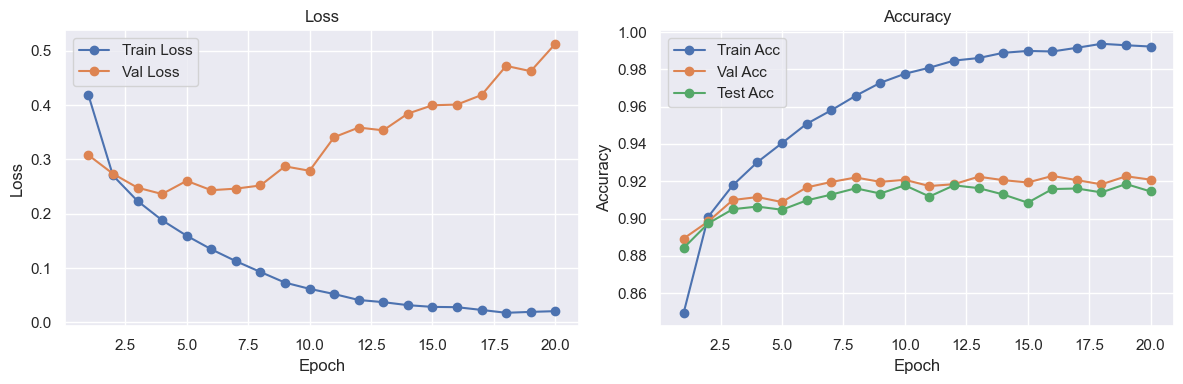

In [ ]:
# Plot training/validation history
plt.figure(figsize=(12,4))

if cnn is None:
    raise ValueError("CNN model not loaded properly.")

plt.subplot(1,2,1)
plt.plot(range(1, cnn.num_epochs+1), cnn.train_losses_cnn, 'o-', label='Train Loss')
plt.plot(range(1, cnn.num_epochs+1), cnn.val_losses_cnn, 'o-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, cnn.num_epochs+1), cnn.train_accuracies_cnn,'o-', label='Train Acc')
plt.plot(range(1, cnn.num_epochs+1), cnn.val_accuracies_cnn, 'o-', label='Val Acc')
plt.plot(range(1, cnn.num_epochs+1), cnn.test_accuracies_cnn, 'o-', label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Results Confusion Matrix

(10, 10)


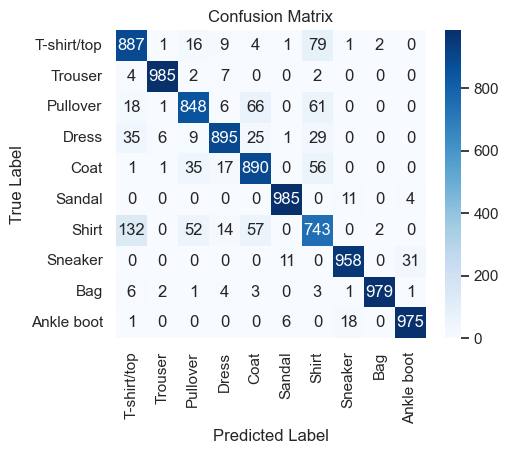

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if cnn is None:
    raise ValueError("CNN model not loaded properly.")

cnn.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader_cnn:
        images = images.to(device)
        outputs = cnn(images)
        # print(F.softmax(outputs, -1))
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
print(cm.shape)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=datasets.FashionMNIST.classes, yticklabels=datasets.FashionMNIST.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## 3.7: CNN with Data Augmentation

In [ ]:
cnn_transform_data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train)
])

full_train_cnn_data_augmentation = datasets.FashionMNIST(root='./data', train=True, download=True, transform=cnn_transform_data_augmentation)
# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_cnn_data_augmentation))
val_size = len(full_train_cnn_data_augmentation) - train_size
# Add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_cnn_data_augmentation, _ = random_split(full_train_cnn_data_augmentation, [train_size, val_size], generator=generator)

batch_size = 64
train_loader_cnn_data_augmentation = DataLoader(train_dataset_cnn_data_augmentation, batch_size=batch_size, shuffle=True, generator=generator)

### CCN with data augmentation Initialization and Training

In [14]:
# Initialize CNN model with data augmentation and train
cnn_aug = load_model('cnn_model_tuned_augmented')
if cnn_aug is None:
    learning_rate = 0.001
    cnn_aug = CNN().to(device)
    optimizer = optim.Adam(cnn_aug.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    cnn_aug.train_cnn(20, optimizer, loss_fn, train_loader_cnn_data_augmentation, val_loader_cnn, test_loader_cnn, device)
    save_model(cnn_aug, 'cnn_model_tuned_augmented')

Model loaded from saved_models/cnn_model_tuned_augmented.pkl


Model loaded from saved_models/cnn_model_tuned.pkl
Model loaded from saved_models/cnn_model_tuned_augmented.pkl


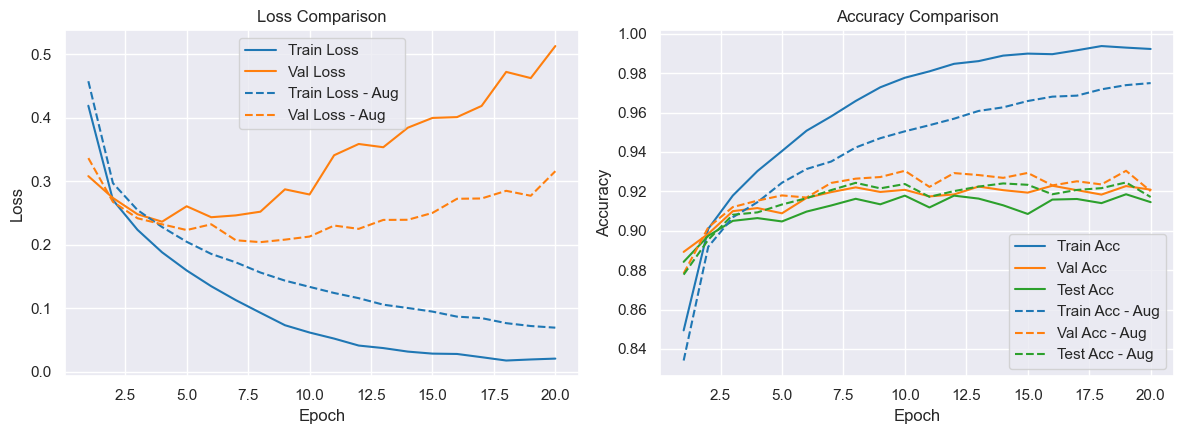

Training time without augmentation: 184.60 seconds
Training time with augmentation: 207.87 seconds


In [17]:
# Plot training/validation history of augmented CNN on top of original CNN
plt.figure(figsize=(12,4.5))
colors = ['tab:blue', 'tab:orange', 'tab:green']

cnn = load_model('cnn_model_tuned')
cnn_aug = load_model('cnn_model_tuned_augmented')


if cnn is None:
    raise ValueError("CNN model not loaded properly.")

if cnn_aug is None:
    raise ValueError("CNN_Aug model not loaded properly.")

plt.subplot(1,2,1)
plt.plot(range(1, cnn.num_epochs+1), cnn.train_losses_cnn, label='Train Loss', color=colors[0])
plt.plot(range(1, cnn.num_epochs+1), cnn.val_losses_cnn, label='Val Loss', color=colors[1])
plt.plot(range(1, cnn_aug.num_epochs+1), cnn_aug.train_losses_cnn, label='Train Loss - Aug', linestyle='--', color=colors[0])
plt.plot(range(1, cnn_aug.num_epochs+1), cnn_aug.val_losses_cnn, label='Val Loss - Aug', linestyle='--', color=colors[1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, cnn.num_epochs+1), cnn.train_accuracies_cnn, label='Train Acc', color=colors[0])
plt.plot(range(1, cnn.num_epochs+1), cnn.val_accuracies_cnn, label='Val Acc', color=colors[1])
plt.plot(range(1, cnn.num_epochs+1), cnn.test_accuracies_cnn, label='Test Acc', color=colors[2])
plt.plot(range(1, cnn_aug.num_epochs+1), cnn_aug.train_accuracies_cnn, label='Train Acc - Aug', linestyle='--', color=colors[0])
plt.plot(range(1, cnn_aug.num_epochs+1), cnn_aug.val_accuracies_cnn, label='Val Acc - Aug', linestyle='--', color=colors[1])
plt.plot(range(1, cnn_aug.num_epochs+1), cnn_aug.test_accuracies_cnn, label='Test Acc - Aug', linestyle ='--', color=colors[2])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Compare training times
print(f"Training time without augmentation: {cnn.train_time:.2f} seconds")
print(f"Training time with augmentation: {cnn_aug.train_time:.2f} seconds")

In [31]:
cnn = load_model('cnn_model_tuned')
cnn_aug = load_model('cnn_model_tuned_augmented')

df = pd.DataFrame({
    "Epoch": list(range(1, 21)),
    "CNN Val Loss": cnn.val_losses_cnn,
    "CNN Test Acc": cnn.test_accuracies_cnn, 
    "CNN Aug Val Loss": cnn_aug.val_losses_cnn,
    "CNN Aug Test Acc": cnn_aug.test_accuracies_cnn
})

display(df)

# Find maximum accuracy and minimum loss for all four columns
cnn_val_loss_min_idx = df['CNN Val Loss'].idxmin()
cnn_val_loss_min_epoch = df.loc[cnn_val_loss_min_idx, 'Epoch']
cnn_val_loss_min = df.loc[cnn_val_loss_min_idx, 'CNN Val Loss']

cnn_test_acc_max_idx = df['CNN Test Acc'].idxmax()
cnn_test_acc_max_epoch = df.loc[cnn_test_acc_max_idx, 'Epoch']
cnn_test_acc_max = df.loc[cnn_test_acc_max_idx, 'CNN Test Acc']

cnn_aug_val_loss_min_idx = df['CNN Aug Val Loss'].idxmin()
cnn_aug_val_loss_min_epoch = df.loc[cnn_aug_val_loss_min_idx, 'Epoch']
cnn_aug_val_loss_min = df.loc[cnn_aug_val_loss_min_idx, 'CNN Aug Val Loss']

cnn_aug_test_acc_max_idx = df['CNN Aug Test Acc'].idxmax()
cnn_aug_test_acc_max_epoch = df.loc[cnn_aug_test_acc_max_idx, 'Epoch']
cnn_aug_test_acc_max = df.loc[cnn_aug_test_acc_max_idx, 'CNN Aug Test Acc']

print(f"\nMaximum accuracy and minimum loss:")
print(f"CNN Val Loss - Epoch: {cnn_val_loss_min_epoch}, Min value: {cnn_val_loss_min:.4f}")
print(f"CNN Test Acc - Epoch: {cnn_test_acc_max_epoch}, Max value: {cnn_test_acc_max:.4f}")
print(f"CNN Aug Val Loss - Epoch: {cnn_aug_val_loss_min_epoch}, Min value: {cnn_aug_val_loss_min:.4f}")
print(f"CNN Aug Test Acc - Epoch: {cnn_aug_test_acc_max_epoch}, Max value: {cnn_aug_test_acc_max:.4f}")

Model loaded from saved_models/cnn_model_tuned.pkl
Model loaded from saved_models/cnn_model_tuned_augmented.pkl


,Epoch,CNN Val Loss,CNN Test Acc,CNN Aug Val Loss,CNN Aug Test Acc
0,1,0.307962,0.8842,0.336356,0.8777
1,2,0.273615,0.8974,0.267486,0.8954
2,3,0.247970,0.9050,0.241665,0.9081
3,4,0.236272,0.9064,0.232139,0.9093
4,5,0.260539,0.9047,0.223099,0.9133
5,6,0.243298,0.9097,0.232164,0.9165
6,7,0.246177,0.9128,0.207030,0.9206
7,8,0.252004,0.9162,0.204065,0.9243
8,9,0.287194,0.9134,0.208007,0.9215
9,10,0.279074,0.9178,0.212844,0.9237



Maximum accuracy and minimum loss:
CNN Val Loss - Epoch: 4, Min value: 0.2363
CNN Test Acc - Epoch: 19, Max value: 0.9185
CNN Aug Val Loss - Epoch: 8, Min value: 0.2041
CNN Aug Test Acc - Epoch: 19, Max value: 0.9245


## 3.8: Pretrained ResNet 

### Load ResNet18

In [ ]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torchinfo import summary
# Load a pre-trained ResNet-18 model
ResNet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
summary(ResNet18)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728

### Prepare ResNet18 for Modification

In [ ]:
# Freeze all convolutional layers
for param in ResNet18.parameters():
    param.requires_grad = False

# Modify First Layer for Grayscale Input
ResNet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Remove the fully connected layers (fc layer)
ResNet18.fc = nn.Identity() # Replace fc with identity # type: ignore
summary(ResNet18)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            3,136
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  (36,864)
│    │    └─BatchNorm2d: 3-2             (128)
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  (36,864)
│    │    └─BatchNorm2d: 3-5             (128)
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  (36,864)
│    │    └─BatchNorm2d: 3-7             (128)
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  (36,864)
│    │    └─BatchNorm2d: 3-10            (128)
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11     

### Custom ResNet18 Class

In [ ]:
import custom_ResNet
importlib.reload(custom_ResNet)     # reloads the module from disk
from custom_ResNet import CustomResNet18  # rebinds names in notebook namespace

In [ ]:
# Device (use GPU if available but don't change MLP behavior)
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
if device == "cpu":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Using device:', device)

Using device: mps


### Hyperparameter Tuning

#### One layer added

In [ ]:
# Initialize CNN model and train
custom_resnet18_one_layers =  None #load_model('cnn_ResNet18_1_layers')
if custom_resnet18_one_layers is None: 
    learning_rate = 0.001
    num_classes = 10
    fc_layer = nn.Sequential(
        nn.Linear(512, num_classes)  # ResNet18's last feature map has 512 channels
    )
    custom_resnet18_one_layers = CustomResNet18(ResNet18, fc_layer).to(device)
    optimizer = optim.Adam(custom_resnet18_one_layers.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    custom_resnet18_one_layers.train_cnn(20, optimizer, loss_fn, train_loader_cnn_data_augmentation, val_loader_cnn, test_loader_cnn, device)
    save_model(custom_resnet18_one_layers, 'cnn_ResNet18_1_layers')

summary(custom_resnet18_one_layers)

Epoch 1/20: Train loss=1.0713, Train acc=62.40%, Val loss=0.8134, Val acc=70.89%, Test acc=71.28%
Epoch 2/20: Train loss=0.8075, Train acc=70.79%, Val loss=0.7001, Val acc=74.98%, Test acc=74.27%
Epoch 3/20: Train loss=0.7477, Train acc=72.94%, Val loss=0.6824, Val acc=75.94%, Test acc=75.89%
Epoch 4/20: Train loss=0.7222, Train acc=73.83%, Val loss=0.6714, Val acc=75.83%, Test acc=75.56%
Epoch 5/20: Train loss=0.7044, Train acc=74.58%, Val loss=0.6488, Val acc=76.12%, Test acc=75.92%
Epoch 6/20: Train loss=0.7024, Train acc=74.70%, Val loss=0.6502, Val acc=75.76%, Test acc=76.32%
Epoch 7/20: Train loss=0.6887, Train acc=75.01%, Val loss=0.6196, Val acc=77.80%, Test acc=77.09%
Epoch 8/20: Train loss=0.6747, Train acc=75.68%, Val loss=0.6022, Val acc=78.30%, Test acc=77.95%
Epoch 9/20: Train loss=0.6645, Train acc=75.90%, Val loss=0.6080, Val acc=77.76%, Test acc=77.71%
Epoch 10/20: Train loss=0.6582, Train acc=76.42%, Val loss=0.5849, Val acc=78.56%, Test acc=78.83%
Epoch 11/20: Train 

Layer (type:depth-idx)                        Param #
CustomResNet18                                --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            3,136
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   (73,984)
│    │    └─BasicBlock: 3-2                   (73,984)
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   (230,144)
│    │    └─BasicBlock: 3-4                   (295,424)
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   (919,040)
│    │    └─BasicBlock: 3-6                   (1,180,672)
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   (3,673,088)
│    │    └─BasicBlock: 3-8                   (4,720,640

#### Two layers added

In [ ]:
# Initialize CNN model and train
custom_resnet18_two_layers = load_model('cnn_ResNet18_2_layers')
if custom_resnet18_two_layers is None: 
    learning_rate = 0.001
    fc_layers = nn.Sequential(
        nn.Linear(512, 256),  # ResNet18's last feature map has 512 channels
        nn.ReLU(),
        nn.Linear(256, num_classes)
    )
    custom_resnet18_two_layers = CustomResNet18(ResNet18, fc_layers).to(device)
    optimizer = optim.Adam(custom_resnet18_two_layers.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    custom_resnet18_two_layers.train_cnn(10, optimizer, loss_fn, train_loader_cnn_data_augmentation, val_loader_cnn, test_loader_cnn, device)
    save_model(custom_resnet18_two_layers, 'cnn_ResNet18_2_layers')
else:
    custom_resnet18_two_layers.train_cnn(10, optimizer, loss_fn, train_loader_cnn_data_augmentation, val_loader_cnn, test_loader_cnn, device)
    save_model(custom_resnet18_two_layers, 'cnn_ResNet18_2_layers')

summary(custom_resnet18_two_layers)

Model loaded from saved_models/cnn_ResNet18_2_layers.pkl
Epoch 11/20: Train loss=0.5221, Train acc=80.66%, Val loss=0.5030, Val acc=81.71%, Test acc=81.43%
Epoch 12/20: Train loss=0.5270, Train acc=80.52%, Val loss=0.4996, Val acc=81.62%, Test acc=81.56%
Epoch 13/20: Train loss=0.5300, Train acc=80.49%, Val loss=0.5026, Val acc=81.73%, Test acc=81.54%
Epoch 14/20: Train loss=0.5313, Train acc=80.30%, Val loss=0.5004, Val acc=81.70%, Test acc=81.53%
Epoch 15/20: Train loss=0.5303, Train acc=80.43%, Val loss=0.4991, Val acc=81.62%, Test acc=81.89%
Epoch 16/20: Train loss=0.5265, Train acc=80.59%, Val loss=0.5054, Val acc=81.63%, Test acc=81.52%
Epoch 17/20: Train loss=0.5285, Train acc=80.50%, Val loss=0.5027, Val acc=81.43%, Test acc=81.30%
Epoch 18/20: Train loss=0.5305, Train acc=80.28%, Val loss=0.5024, Val acc=81.72%, Test acc=81.30%
Epoch 19/20: Train loss=0.5233, Train acc=80.63%, Val loss=0.5002, Val acc=81.67%, Test acc=81.58%
Epoch 20/20: Train loss=0.5282, Train acc=80.41%, Va

Layer (type:depth-idx)                        Param #
CustomResNet18                                --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            3,136
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   (73,984)
│    │    └─BasicBlock: 3-2                   (73,984)
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   (230,144)
│    │    └─BasicBlock: 3-4                   (295,424)
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   (919,040)
│    │    └─BasicBlock: 3-6                   (1,180,672)
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   (3,673,088)
│    │    └─BasicBlock: 3-8                   (4,720,640

#### Three layers added

In [ ]:
# Initialize CNN model and train
custom_resnet18_three_layers = None # load_model('cnn_ResNet18_3_layers')
if custom_resnet18_three_layers is None: 
    learning_rate = 0.001
    fc_layers = nn.Sequential(
        nn.Linear(512, 256),  # ResNet18's last feature map has 512 channels
        nn.ReLU(),
        nn.Linear(256, 128),  # ResNet18's last feature map has 512 channels
        nn.ReLU(),
        nn.Linear(128, num_classes)
    )
    custom_resnet18_three_layers = CustomResNet18(ResNet18, fc_layers).to(device)
    optimizer = optim.Adam(custom_resnet18_three_layers.parameters(), lr=learning_rate)
    
    loss_fn = nn.CrossEntropyLoss()
    custom_resnet18_three_layers.train_cnn(20, optimizer, loss_fn, train_loader_cnn_data_augmentation, val_loader_cnn, test_loader_cnn, device)
    save_model(custom_resnet18_three_layers, 'cnn_ResNet18_3_layers')

summary(custom_resnet18_three_layers)

Epoch 1/20: Train loss=0.7125, Train acc=74.70%, Val loss=0.5624, Val acc=79.70%, Test acc=79.04%
Epoch 2/20: Train loss=0.6143, Train acc=77.59%, Val loss=0.5620, Val acc=79.89%, Test acc=79.62%
Epoch 3/20: Train loss=0.5901, Train acc=78.48%, Val loss=0.5466, Val acc=80.29%, Test acc=80.12%
Epoch 4/20: Train loss=0.5821, Train acc=78.56%, Val loss=0.5210, Val acc=80.94%, Test acc=80.37%
Epoch 5/20: Train loss=0.5679, Train acc=79.00%, Val loss=0.5416, Val acc=79.96%, Test acc=79.53%
Epoch 6/20: Train loss=0.5570, Train acc=79.55%, Val loss=0.5161, Val acc=81.47%, Test acc=80.94%
Epoch 7/20: Train loss=0.5546, Train acc=79.73%, Val loss=0.5064, Val acc=81.85%, Test acc=81.19%
Epoch 8/20: Train loss=0.5463, Train acc=80.00%, Val loss=0.5148, Val acc=80.98%, Test acc=80.89%
Epoch 9/20: Train loss=0.5391, Train acc=80.04%, Val loss=0.5133, Val acc=81.28%, Test acc=81.38%
Epoch 10/20: Train loss=0.5291, Train acc=80.47%, Val loss=0.5117, Val acc=81.15%, Test acc=80.94%
Epoch 11/20: Train 

Layer (type:depth-idx)                        Param #
CustomResNet18                                --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            3,136
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   (73,984)
│    │    └─BasicBlock: 3-2                   (73,984)
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   (230,144)
│    │    └─BasicBlock: 3-4                   (295,424)
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   (919,040)
│    │    └─BasicBlock: 3-6                   (1,180,672)
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   (3,673,088)
│    │    └─BasicBlock: 3-8                   (4,720,640

### Layer Comparison

Model loaded from saved_models/cnn_ResNet18_1_layers.pkl
Model loaded from saved_models/cnn_ResNet18_2_layers.pkl
Model loaded from saved_models/cnn_ResNet18_3_layers.pkl


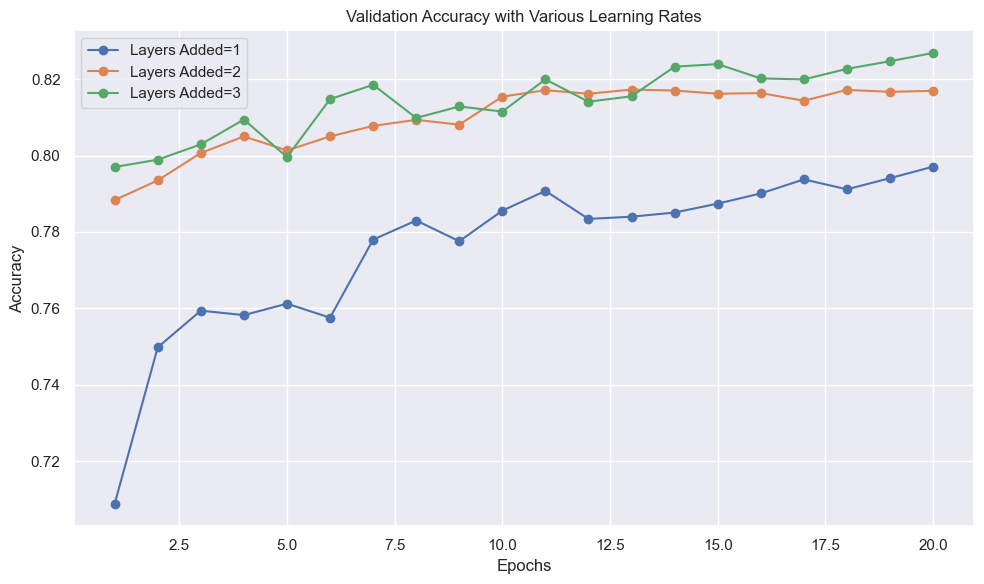

In [ ]:
plt.figure(figsize=(10, 6))
layers = [1,2,3]
for layer in layers:
    resnet_model = load_model(f'cnn_ResNet18_{layer}_layers')
    if resnet_model is None:
        continue
    epochs = range(1, len(resnet_model.val_losses_cnn) + 1)
    plt.plot(epochs, resnet_model.val_accuracies_cnn, marker='o', label=f'Layers Added={layer}')

plt.title('Validation Accuracy with Various Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()


### Plot Results

Model loaded from saved_models/cnn_ResNet18_3_layers.pkl


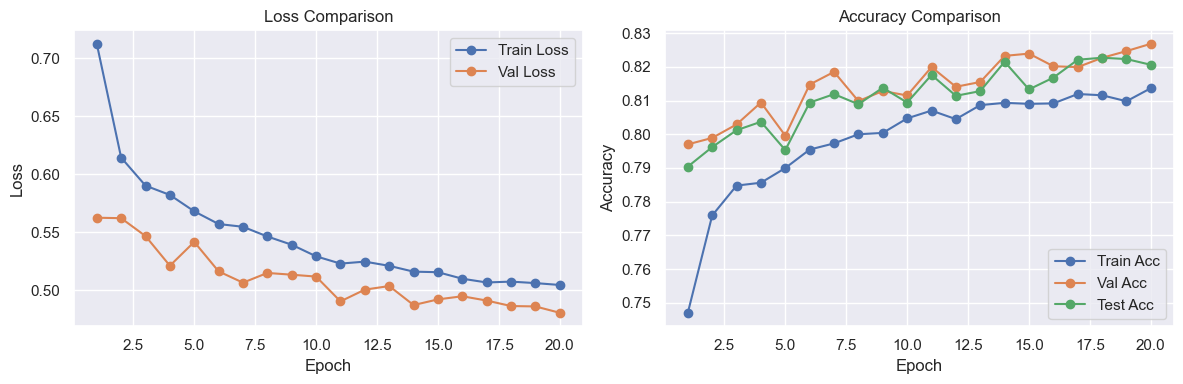

In [ ]:
# Plot training/validation history
plt.figure(figsize=(12,4))

resnet_model = load_model(f'cnn_ResNet18_3_layers')
if resnet_model is None:
    raise ValueError("resnet_model model not loaded properly.")

plt.subplot(1,2,1)
plt.plot(range(1, resnet_model.num_epochs+1), resnet_model.train_losses_cnn, 'o-', label='Train Loss')
plt.plot(range(1, resnet_model.num_epochs+1), resnet_model.val_losses_cnn, 'o-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, resnet_model.num_epochs+1), resnet_model.train_accuracies_cnn, 'o-', label='Train Acc')
plt.plot(range(1, resnet_model.num_epochs+1), resnet_model.val_accuracies_cnn, 'o-', label='Val Acc')
plt.plot(range(1, resnet_model.num_epochs+1), resnet_model.test_accuracies_cnn, 'o-', label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
resnet_model = load_model(f'cnn_ResNet18_3_layers')
print(resnet_model.test_accuracies_cnn)  # type: ignore

Model loaded from saved_models/cnn_ResNet18_3_layers.pkl
[0.7904, 0.7962, 0.8012, 0.8037, 0.7953, 0.8094, 0.8119, 0.8089, 0.8138, 0.8094, 0.8176, 0.8114, 0.8128, 0.8215, 0.8133, 0.8168, 0.8221, 0.8227, 0.8223, 0.8206]


### Results Confusion Matrix

(10, 10)


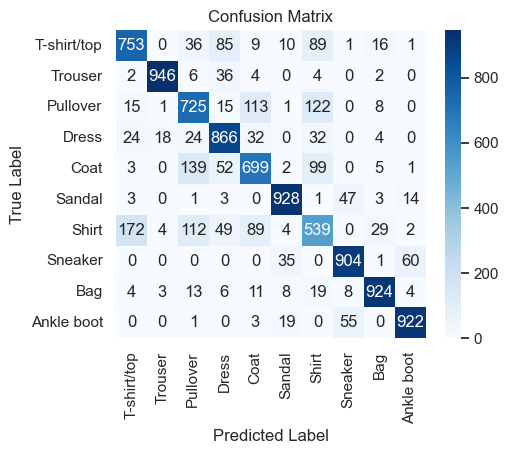

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if resnet_model is None:
    raise ValueError("resnet_model model not loaded properly.")

resnet_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader_cnn:
        images = images.to(device)
        outputs = resnet_model(images)
        # print(F.softmax(outputs, -1))
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
print(cm.shape)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=datasets.FashionMNIST.classes, yticklabels=datasets.FashionMNIST.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()